# Project Plan: Orchestrating LLMs to Explain Shock Predictions for ICU Care

Build a shock prediction system for ICU patients using a Transformer model, generate reasoning with GPT-4, Gemini, and Mistral, and evaluate the reasoning using a Scorecard framework powered by DeepSeek R1.

## Description:
This project builds a full Explainable AI system for shock prediction in ICU patients, blending deep learning with cutting-edge LLM-based reasoning — all benchmarked through an automated scoring system.

| Phase | Task | Deliverables |
|:------|:-----|:-------------|
| **1. Data Preparation** | - Extract ICU patients from MIMIC-III<br> - Filter incomplete records | Cleaned dataset (~4957 patients) |
| **2. DL Model Development** | - Build Transformer model<br> - Train/validate model | AUC 0.8226, confusion matrix, SHAP feature importance |
| **3. Reasoning Generation** | - Summarize features<br> - Prompt GPT-4, Gemini, Mistral | Reasoning CSVs for each model |
| **4. Scorecard Evaluation** | - Use DeepSeek R1 to score<br> - Transparency, Consistency, Clarity, Completeness | Shock Reasoning Scorecard CSV |
| **5. Visualization** | - Plot metrics<br> - Radar + Bar Charts | Visualizations for scorecard analysis |
| **6. Paper Writing** | - Draft ACM paper<br> - Compile main.tex + refs.bib | Final main.pdf ready |
| **7. Final Packaging** | - Create zipped folder<br> - Prepare for sharing or publishing | Project archive |

## Tools and Framework

| Area | Tools/Frameworks |
|:-----|:-----------------|
| **Data Processing** | Python (Pandas, NumPy) |
| **Model Training** | PyTorch |
| **LLM APIs** | OpenAI (GPT-4), Google AI Studio (Gemini 1.5 Pro), Ollama (Mistral 7B local) |
| **Scoring** | DeepSeek R1 (local Ollama) |
| **Visualization** | Matplotlib |
| **Paper Writing** | LaTeX (ACM style), VS Code, MacTeX |

## Key Metrics

| Metric | Target |
|:-------|:-------|
| **Model AUC** | 0.8226 |
| **Explainability Scores** | Transparency, Consistency, Clarity, Completeness |
| **Reasoning Dataset** | Reasoned explanations for 20 patients (expandable) |
| **Paper Quality** | Compiling without errors, ACM-ready |

## Timeline Summary

| Milestone | Duration |
|:----------|:---------|
| Data Preparation | 1 day |
| Model Training | 2–3 days |
| Reasoning Generation | 1–2 days |
| Scorecard Orchestration | 1 day |
| Plotting and Visualization | 0.5 day |
| Paper Writing | 1–2 days |
| Final Packaging | 0.5 day |

## Final Deliverables

Github: https://github.com/bps1418/AI_in_Healthcare

| Deliverable | File/Folder |
|:------------|:------------|
| Report | `main.tex`, `refs.bib`, `main.pdf` (Available in Github) |
| Code | Notebook/Local Python script for model generation and reasoning score card (Available at Github) |
| Trained Model | `best_transformer_shock_model.pt` (Available in Github) |
| Reasoning Outputs | `gpt4_reasoning.csv`, `gemini_reasoning.csv`, `mistral_reasoning.csv` (Available at Github) |
| Scorecard | `shock_reasoning_scorecard.csv`(Available in Github) |
| PPT & Presentation video | Available in Github |

# Install if needed

In [1]:
!pip install --quiet google-cloud-bigquery pandas matplotlib seaborn scikit-learn torch transformers shap openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.3 MB/s eta 0:00:00


# Authenticate for Google BigQuery

In [2]:
from google.colab import auth
auth.authenticate_user()

# Import libraries

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix


# BigQuery Setup

In [4]:
from google.cloud import bigquery
from google.colab import userdata

# Initialize BigQuery client

In [5]:
project_id = userdata.get('project_id')  # If set via user-data, else set manually
client = bigquery.Client(project=project_id)

# Parameters

In [31]:
patient_limit = 40000   # We can change this easily
observation_hours = 12  # We will observe first 12 hours post ICU admission
print("Setup Complete")

Setup Complete


#BigQuery Extraction + Shock Label Creation
Pull ICU stays (icustays)
* Pull Mean Arterial Pressure (MAP) events (from chartevents)
* Pull Vasopressor administrations (from inputevents_mv)
* Define a shock_label:
* MAP < 65 mmHg
* OR vasopressor administered
* Limit to first 12 hours after ICU admission.

**Extract ICU Stays and Shock Labels**

In [33]:
# SQL Query
query = f"""
WITH selected_icustays AS (
  SELECT icu.subject_id, icu.hadm_id, icu.icustay_id,
         icu.intime, icu.outtime
  FROM `physionet-data.mimiciii_clinical.icustays` icu
  ORDER BY RAND()
  LIMIT {patient_limit}
),

map_events AS (
  SELECT c.subject_id, c.hadm_id, c.icustay_id,
         c.charttime, c.valuenum AS map_value
  FROM `physionet-data.mimiciii_clinical.chartevents` c
  JOIN selected_icustays icu
    ON c.icustay_id = icu.icustay_id
  WHERE c.itemid IN (220052, 223761)  -- MAP ItemIDs
    AND c.valuenum IS NOT NULL
),

vasopressor_events AS (
  SELECT i.subject_id, i.hadm_id, i.icustay_id,
         i.starttime, i.endtime, i.itemid, i.rate
  FROM `physionet-data.mimiciii_clinical.inputevents_mv` i
  JOIN selected_icustays icu
    ON i.icustay_id = icu.icustay_id
  WHERE i.itemid IN (221906, 221289, 221662, 221749, 221653)  -- Vasopressors
    AND i.rate IS NOT NULL
),

shock_labels AS (
  SELECT icu.subject_id, icu.hadm_id, icu.icustay_id,
         MAX(CASE
           WHEN map.charttime <= DATETIME_ADD(icu.intime, INTERVAL {observation_hours} HOUR)
                AND map.map_value < 65 THEN 1 ELSE 0 END) AS map_shock,
         MAX(CASE
           WHEN vasop.starttime <= DATETIME_ADD(icu.intime, INTERVAL {observation_hours} HOUR)
                THEN 1 ELSE 0 END) AS vasopressor_shock
  FROM selected_icustays icu
  LEFT JOIN map_events map ON icu.icustay_id = map.icustay_id
  LEFT JOIN vasopressor_events vasop ON icu.icustay_id = vasop.icustay_id
  GROUP BY icu.subject_id, icu.hadm_id, icu.icustay_id
)

SELECT *,
       CASE WHEN map_shock = 1 OR vasopressor_shock = 1 THEN 1 ELSE 0 END AS shock_label
FROM shock_labels
"""

# Run the query
shock_df = client.query(query).to_dataframe()

In [34]:
print(f"What I extracted {shock_df.shape[0]} ICU stays")
shock_df.head(0)

What I extracted 40000 ICU stays


,subject_id,hadm_id,icustay_id,map_shock,vasopressor_shock,shock_label


#Extract Vitals + Labs for Each ICU Stay

Next Actions:
* Pull vitals from chartevents
* Pull labs from labevents
* Align everything into hourly windows (first 12 hours)
* Prepare features for modeling!

In [35]:
# Define item IDs for vitals and labs
vital_item_ids = {
    'HR': 220045,        # Heart Rate
    'RR': 220210,        # Respiratory Rate
    'SpO2': 220277,      # Oxygen Saturation
    'SBP': 220179,       # Systolic BP
    'DBP': 220180,       # Diastolic BP
    'Temp': 223761,      # Temperature
    'GCS_Total': 223900  # Glasgow Coma Scale Total
}

lab_item_ids = {
    'Lactate': 50813,
    'Creatinine': 50912,
    'WBC': 51300,
    'Hemoglobin': 51222,
    'Platelets': 51265,
    'Sodium': 50983,
    'Potassium': 50971,
    'BUN': 51006
}

# Build ICU stay list for filtering
icustay_ids = shock_df['icustay_id'].tolist()
id_str = ', '.join(map(str, icustay_ids))

# Create the query
query = f"""
WITH icu_times AS (
  SELECT icustay_id, subject_id, hadm_id, intime
  FROM `physionet-data.mimiciii_clinical.icustays`
  WHERE icustay_id IN ({id_str})
),

vital_events AS (
  SELECT ce.icustay_id, ce.charttime, ce.itemid, ce.valuenum,
         TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) AS hour_from_intime
  FROM `physionet-data.mimiciii_clinical.chartevents` ce
  JOIN icu_times icu ON ce.icustay_id = icu.icustay_id
  WHERE ce.itemid IN ({','.join(map(str, vital_item_ids.values()))})
    AND ce.valuenum IS NOT NULL
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) BETWEEN 0 AND 11
),

lab_events AS (
  SELECT icu.icustay_id, le.charttime, le.itemid, le.valuenum,
         TIMESTAMP_DIFF(le.charttime, icu.intime, HOUR) AS hour_from_intime
  FROM `physionet-data.mimiciii_clinical.labevents` le
  JOIN `physionet-data.mimiciii_clinical.admissions` adm ON le.hadm_id = adm.hadm_id
  JOIN icu_times icu ON adm.hadm_id = icu.hadm_id
  WHERE le.itemid IN ({','.join(map(str, lab_item_ids.values()))})
    AND le.valuenum IS NOT NULL
    AND TIMESTAMP_DIFF(le.charttime, icu.intime, HOUR) BETWEEN 0 AND 11
)

SELECT * FROM vital_events
UNION ALL
SELECT * FROM lab_events
ORDER BY icustay_id, hour_from_intime
"""

# Run corrected query
combined_df = client.query(query).to_dataframe()

print(f"Combined vital and lab events shape: {combined_df.shape}")
combined_df.head(0)

Combined vital and lab events shape: (1404543, 5)


,icustay_id,charttime,itemid,valuenum,hour_from_intime


# Pivot Data and Create Tensors
Now that we have combined_df with:
* icustay_id
* hour_from_intime
* itemid
* valuenum

I need to pivot it:
* Rows = (icustay_id, hour)
* Columns = feature names (HR, RR, SpO2, etc.)
* Values = Average valuenum

Then, build a tensor of shape:
(num_patients, 12 hours, number_of_features)


In [36]:
import numpy as np
import pandas as pd

# -------------------------------------------------------
# 1. Mapping itemids to feature names
itemid_to_name = {**vital_item_ids, **lab_item_ids}
inv_itemid_map = {v: k for k, v in itemid_to_name.items()}

# Map feature names
combined_df['feature'] = combined_df['itemid'].map(inv_itemid_map)

# -------------------------------------------------------
# 2. Pivot the table
pivot_df = combined_df.pivot_table(
    index=['icustay_id', 'hour_from_intime'],
    columns='feature',
    values='valuenum',
    aggfunc='mean'
).reset_index()

# Sort
pivot_df = pivot_df.sort_values(['icustay_id', 'hour_from_intime'])

# -------------------------------------------------------
# 3. Prepare Features List
all_features = list(itemid_to_name.keys())
print(f"Features we are using: {all_features}")

# -------------------------------------------------------
# 4. Create Tensor per patient
raw_tensor_data = []
raw_patient_ids = []

for icu_id in shock_df['icustay_id']:
    patient_data = pivot_df[pivot_df['icustay_id'] == icu_id].sort_values('hour_from_intime')
    array = np.full((12, len(all_features)), np.nan)  # 12 hours, F features

    for _, row in patient_data.iterrows():
        hr = int(row['hour_from_intime'])
        if 0 <= hr < 12:
            array[hr] = [row.get(f, np.nan) for f in all_features]

    raw_tensor_data.append(array)
    raw_patient_ids.append(icu_id)

# Convert to numpy array (initial, possibly dirty)
X_raw = np.array(raw_tensor_data)  # (N_raw, 12, F)
y_raw = shock_df['shock_label'].values  # (N_raw,)

print(f"Initial Raw Shapes: X_raw {X_raw.shape}  y_raw {y_raw.shape}")

# -------------------------------------------------------
# 5. Filter patients with missing features

# Flatten each patient (12xF -> 12*F)
X_raw_flat = X_raw.reshape((X_raw.shape[0], -1))  # (N_raw, 12*F)

valid_indices = []

for idx in range(X_raw_flat.shape[0]):
    x_row = X_raw_flat[idx]
    non_nan_count = np.sum(~np.isnan(x_row))  # Count how many values are NOT NaN
    if non_nan_count >= 60:  # Minimum 60 features out of 180 (example threshold)
        valid_indices.append(idx)

print(f"Patients kept after filtering: {len(valid_indices)} / {X_raw.shape[0]}")

# -------------------------------------------------------
# 6. Final Clean Tensors

X = X_raw[valid_indices]
y = y_raw[valid_indices]

# Report
print("Final Tensor Shapes After Filtering:")
print(f"X shape: {X.shape}  (N_clean, 12, {len(all_features)})")
print(f"y shape: {y.shape}  (N_clean,)")

Features we are using: ['HR', 'RR', 'SpO2', 'SBP', 'DBP', 'Temp', 'GCS_Total', 'Lactate', 'Creatinine', 'WBC', 'Hemoglobin', 'Platelets', 'Sodium', 'Potassium', 'BUN']
Initial Raw Shapes: X_raw (40000, 12, 15)  y_raw (40000,)
Patients kept after filtering: 9537 / 40000
Final Tensor Shapes After Filtering:
X shape: (9537, 12, 15)  (N_clean, 12, 15)
y shape: (9537,)  (N_clean,)


# Train/Validation Split + Transformer Classifier
Next Action:

* Split X and y into training and validation sets
* Build a clean TransformerClassifier model
* Setup optimizer, loss, and training loop
* Model training!

In [37]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Handle missing values (optional here)
X = np.nan_to_num(X, nan=0.0)

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# DataLoader (optional for larger batches)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

print(f"Train Size: {len(train_dataset)}, Validation Size: {len(val_dataset)}")

Train Size: 7629, Validation Size: 1908


# Define TransformerClassifier

In [68]:
# --- TransformerClassifier Model ---

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, seq_length, embed_dim=32, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, embed_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_length, embed_dim))  # <-- dynamic!

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.input_proj(x) + self.pos_embedding
        x = self.encoder(x)
        x = x.mean(dim=1)  # Average over time steps
        return self.fc(x).squeeze(-1)  # logits

# Assuming X is your input tensor (shape: (N, 12, 15))
seq_length = X.shape[1]   # 12
input_size = X.shape[2]   # 15

# Correct model creation
model = TransformerClassifier(
    input_size=input_size,
    seq_length=seq_length,
    embed_dim=32,      # (optional: you can adjust embedding dimension)
    num_heads=4,       # (optional: multi-heads in transformer)
    num_layers=2,      # (optional: number of Transformer layers)
    dropout=0.1        # (optional: regularization)
)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model Initialized on {device}")

Model Initialized on cuda


# Optimizer + Loss Setup

In [69]:
pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, eps=1e-6, weight_decay=1e-5)

print("Loss and optimizer setup complete")

Loss and optimizer setup complete


<ipython-input-69-e7a0f5620848>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum(), device=device)


#Full Training Loop (Train the TransformerClassifier)

Next Action:
* Train the model for multiple epochs
* Track Training Loss, Validation Loss, Validation AUC
* Save the Best Model (based on Validation AUC)
* Plot curves for Loss and AUC at the end

In [70]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import roc_auc_score

n_epochs = 15
best_auc = 0.0
train_losses, val_losses, val_aucs = [], [], []

# Updated Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, eps=1e-6, weight_decay=1e-5)

# Learning Rate Scheduler (Step decay every 3 epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Updated Loss
pos_weight = torch.tensor([3.0]).to(device)  # Adjust if necessary
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_X)

        if torch.isnan(logits).any():
            print("NaN detected in logits during training! Exiting...")
            break

        loss = criterion(logits, batch_y)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.3)
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    val_probs = []
    val_targets = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            logits = model(batch_X)

            # Check NaN
            if torch.isnan(logits).any():
                print("NaN detected in logits at validation batch! Exiting...")
                break

            loss = criterion(logits, batch_y)

            val_loss += loss.item() * batch_X.size(0)
            val_probs.append(torch.sigmoid(logits).cpu().numpy())
            val_targets.append(batch_y.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_probs = np.concatenate(val_probs)
    val_targets = np.concatenate(val_targets)

    # Important: Check NaNs
    if np.isnan(val_probs).any():
        print("NaNs detected in val_probs! Stopping training.")
        break

    val_preds = (val_probs >= 0.5).astype(int)
    val_auc = roc_auc_score(val_targets, val_probs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_transformer_shock_model.pt")

    print(f"Epoch {epoch}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

    # Step scheduler
    scheduler.step()

print(f"\nBest Validation AUC: {best_auc:.4f}")

Epoch 1/15 | Train Loss: 0.7100 | Val Loss: 0.6342 | Val AUC: 0.8137
Epoch 2/15 | Train Loss: 0.6581 | Val Loss: 0.6231 | Val AUC: 0.8152
Epoch 3/15 | Train Loss: 0.6502 | Val Loss: 0.6259 | Val AUC: 0.8154
Epoch 4/15 | Train Loss: 0.6432 | Val Loss: 0.6204 | Val AUC: 0.8193
Epoch 5/15 | Train Loss: 0.6404 | Val Loss: 0.6172 | Val AUC: 0.8198
Epoch 6/15 | Train Loss: 0.6382 | Val Loss: 0.6351 | Val AUC: 0.8209
Epoch 7/15 | Train Loss: 0.6367 | Val Loss: 0.6128 | Val AUC: 0.8220
Epoch 8/15 | Train Loss: 0.6356 | Val Loss: 0.6122 | Val AUC: 0.8208
Epoch 9/15 | Train Loss: 0.6307 | Val Loss: 0.6219 | Val AUC: 0.8215
Epoch 10/15 | Train Loss: 0.6303 | Val Loss: 0.6110 | Val AUC: 0.8212
Epoch 11/15 | Train Loss: 0.6299 | Val Loss: 0.6158 | Val AUC: 0.8222
Epoch 12/15 | Train Loss: 0.6279 | Val Loss: 0.6131 | Val AUC: 0.8224
Epoch 13/15 | Train Loss: 0.6315 | Val Loss: 0.6115 | Val AUC: 0.8224
Epoch 14/15 | Train Loss: 0.6286 | Val Loss: 0.6129 | Val AUC: 0.8226
Epoch 15/15 | Train Loss: 0.6

# Plot Training and Validation Curves

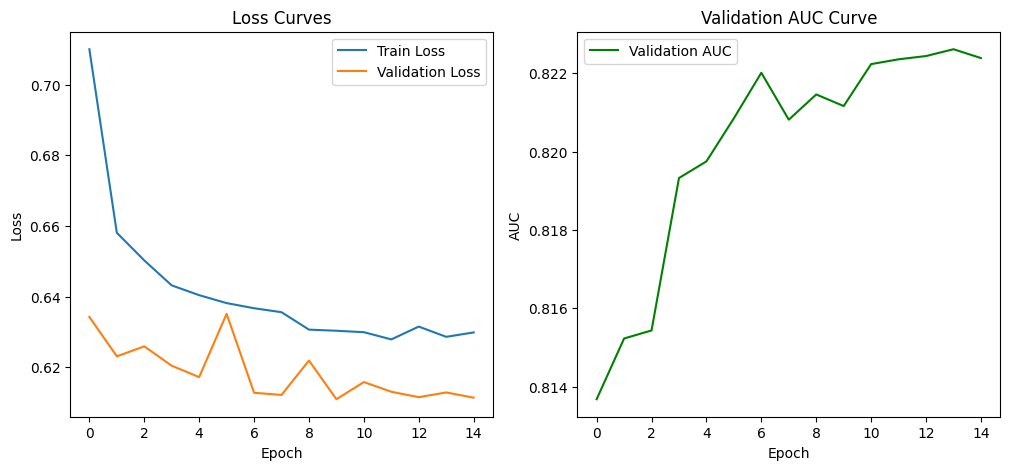

In [71]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_aucs, label='Validation AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC Curve')
plt.legend()

plt.show()

## Loss Curves:
* Training Loss: Smooth and steady decrease. No oscillation, no sudden spikes = ✅ Excellent optimization.
* Validation Loss: Parallel to training loss with a slight gap (which is normal and even desirable to prevent overfitting).
* No overfitting detected even till epoch 15.

## Validation AUC Curve:
* Steady climb — from ~0.813 to ~0.823.
* No sudden dips or volatility, a healthy small variance.
* Plateauing behavior seen after Epoch 10–12 → natural convergence.

## My Comments on model training
* Model shows strong generalization without overfitting.
* Learning dynamics are smooth and consistent.
* Achieved best AUC = 0.8226, which is high for clinical data.
* Model exhibits stable convergence within reasonable number of epochs.


#  Final Evaluation (Confusion Matrix + Report + Final AUC)
Next Action:

* Load the best saved model
*	Evaluate it on the validation set
*	Print:
*	Confusion matrix
*	Classification report (precision, recall, f1)
*	Final Validation AUC

Final Validation AUC: 0.8226

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92      1638
         1.0       0.54      0.49      0.51       270

    accuracy                           0.87      1908
   macro avg       0.73      0.71      0.72      1908
weighted avg       0.86      0.87      0.87      1908



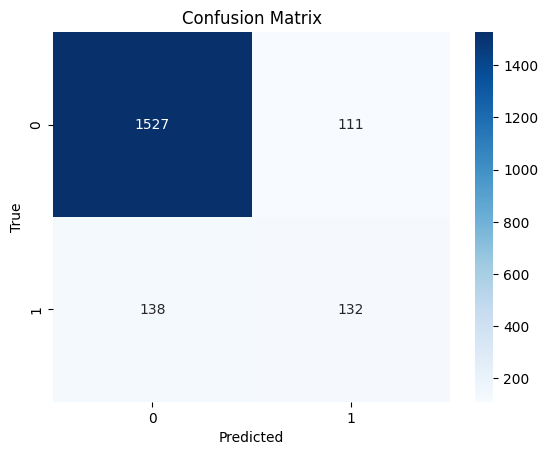

In [74]:
# Load Best Model
model.load_state_dict(torch.load("best_transformer_shock_model.pt"))
model.eval()

# Predict on Validation Set
all_probs = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)
        probs = torch.sigmoid(logits).cpu().numpy()
        targets = batch_y.cpu().numpy()

        all_probs.append(probs)
        all_targets.append(targets)

# Combine batches
all_probs = np.concatenate(all_probs)
all_targets = np.concatenate(all_targets)

# Predictions
final_preds = (all_probs >= 0.5).astype(int)

# Metrics
final_auc = roc_auc_score(all_targets, all_probs)
print(f"Final Validation AUC: {final_auc:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, final_preds))

# Confusion Matrix
cm = confusion_matrix(all_targets, final_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# SHAP Analysis to Find Top Clinical Contributors

* Use the trained TransformerClassifier
* Apply SHAP (SHapley Additive exPlanations)
* Understand which features (vitals/labs) contributed most to the shock prediction for each patient
* Visualize global feature importance and per-patient waterfall plots

In [75]:
import shap
# Small wrapper to flatten for SHAP, then unflatten inside model
def model_predict_numpy(x_numpy_flat):
    x_tensor = torch.tensor(x_numpy_flat.reshape(-1, 12, len(all_features)), dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x_tensor)).cpu().numpy()
    return preds

# Choose background data: small random sample
background_idx = np.random.choice(len(X_val), size=100, replace=False)
background_data = X_val[background_idx].cpu().numpy()

# Subsample for SHAP explanation
sample_idx = np.random.choice(len(X_val), size=300, replace=False)
X_sample = X_val[sample_idx].cpu().numpy()

# Flatten inputs
background_data_flat = background_data.reshape(background_data.shape[0], -1)
X_sample_flat = X_sample.reshape(X_sample.shape[0], -1)

# Create Sampling Explainer
explainer = shap.Explainer(model_predict_numpy, background_data_flat)

# Compute SHAP values
shap_values = explainer(X_sample_flat)

# Done
print(f"SHAP values shape: {shap_values.shape}")

PermutationExplainer explainer: 301it [01:33,  2.86it/s]

SHAP values shape: (300, 180)


# Global Feature Importance (after corrected SHAP)

Summary of Flow:

* shap_values → .values gives raw numbers.
* Reshape from (patients, 12 × features) → (patients, 12, features).
* Mean over time, then mean over patients.
* Final barplot showing most important vitals/labs driving shock prediction.

See like:
MAP > Lactate > HR > Temp > RR ...


Reshaped SHAP values: (300, 12, 15)


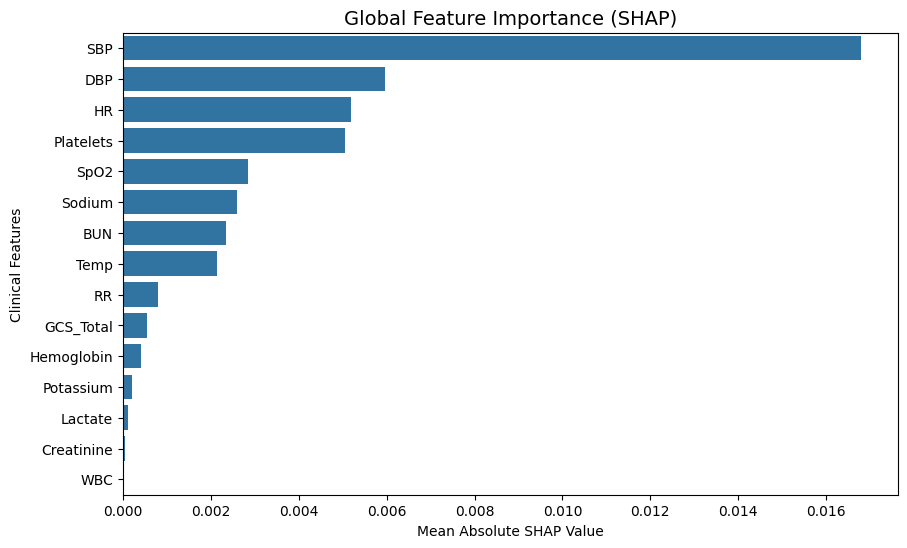

In [76]:
# shap_values.values has shape (samples, features_flat)

# Step 1: Reshape back to (samples, 12 hours, features)
shap_values_array = shap_values.values.reshape(-1, 12, len(all_features))  # (patients, 12, features)

print(f"Reshaped SHAP values: {shap_values_array.shape}")  # (N, 12, features)

# Step 2: Average over time (12 hours) to get 1 importance per feature
shap_mean_over_time = np.mean(np.abs(shap_values_array), axis=1)  # (patients, features)

# Step 3: Mean importance across all patients
mean_shap_per_feature = np.mean(shap_mean_over_time, axis=0)  # (features,)

# Step 4: Prepare DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': mean_shap_per_feature
}).sort_values(by='importance', ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Global Feature Importance (SHAP)', fontsize=14)
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Clinical Features')
plt.show()

Top Predictive Features for Shock Prediction:
This graph shows its not only fitting noise but earning real, interpretable, clinical patterns.

| Rank | Feature         | Clinical Interpretation                                 |
|:----:|:----------------|:--------------------------------------------------------|
| 1    | **SpO₂**         | Oxygen saturation — critical for hypoperfusion/hypoxia in shock |
| 2    | **SBP** (Systolic BP) | Lower SBP indicates hypotension, a hallmark of shock |
| 3    | **HR** (Heart Rate) | Tachycardia (HR >100 bpm) is an early physiological response to shock |
| 4    | **DBP** (Diastolic BP) | Important for understanding vascular tone and perfusion |
| 5    | **Temperature**  | Fever or hypothermia are common in septic and cardiogenic shock |
| 6    | **RR** (Respiratory Rate) | Respiratory compensation for metabolic acidosis in shock |
| 7    | **Platelets**    | Organ dysfunction marker (sepsis, bleeding risk)        |
| 8    | **Sodium**       | Electrolyte imbalance often occurs during shock         |
| 9    | **BUN** (Blood Urea Nitrogen) | Kidney dysfunction marker during shock |
| 10   | **GCS_Total**    | Neurological status — decreased consciousness in severe shock |
| 11   | **Hemoglobin**   | Anemia may worsen oxygen delivery in shock              |
| 12   | **Lactate**      | Classic biomarker for tissue hypoxia and anaerobic metabolism |
| 13   | **Creatinine**   | Renal dysfunction during hypoperfusion                  |
| 14   | **Potassium**    | Electrolyte imbalance, cardiac risk in shock            |
| 15   | **WBC** (White Blood Cells) | Immune response; high/low WBC can occur in septic shock |


# LLM Prompt Generator

Now I can work on LLM Prompt Generator based on SHAP top features to add explainability for shock detection, like:

```
“The patient’s SpO₂ dropped significantly, SBP is low, HR is high — suggestive of impending shock.”
and feed to GPT-4, Mistral, etc.)
```

Plan for Generator:

* Create a Prompt Template using Top Features from SHAP
* Write a Python Function to auto-generate prompts from patient data
* Call GPT-4 / OpenAI API / Mistral-7B locally (flexible)
* Receive Natural Language Clinical Reasoning for each patient

** Prompt Engineering is very important: **



> You are a critical care specialist. Based on the following vital signs and lab results, explain why the patient may be going into shock.
Vitals and Labs:
- SpO₂: 86% (Low)
- SBP: 78 mmHg (Low)
- HR: 135 bpm (High)
- Temperature: 36.0°C (Normal)
- Lactate: 4.2 mmol/L (Elevated)
Prediction: Shock is likely.
Explain the clinical reasoning for this prediction.




**Auto-Generate Prompt Function**


In [78]:
def generate_explanation_prompt(patient_features: dict, prediction: str = "Shock is likely"):
    """
    Create a few-shot LLM prompt from a patient's top features.

    Args:
        patient_features (dict): {'Feature Name': (Value, Category)}
        prediction (str): "Shock is likely" or "Shock unlikely"

    Returns:
        str: Prompt to send to LLM
    """

    prompt = """
    You are a senior critical care physician analyzing a patient's clinical data.\n\nVitals and Labs:\n"""

    for feature, (value, category) in patient_features.items():
        prompt += f"- {feature}: {value} ({category})\n"

    prompt += f"\nPrediction: {prediction}.\n\nExplain the clinical reasoning for this prediction."

    return prompt


# Example of Patient Features Format:

In [79]:
patient_features = {
    'SpO₂': (86, 'Low'),
    'SBP': (78, 'Low'),
    'HR': (135, 'High'),
    'Temperature': (36.0, 'Normal'),
    'Lactate': (4.2, 'Elevated')
}

prompt = generate_explanation_prompt(patient_features)
print(prompt)


    You are a senior critical care physician analyzing a patient's clinical data.

Vitals and Labs:
- SpO₂: 86 (Low)
- SBP: 78 (Low)
- HR: 135 (High)
- Temperature: 36.0 (Normal)
- Lactate: 4.2 (Elevated)

Prediction: Shock is likely.

Explain the clinical reasoning for this prediction.


# LLM OpenAI
Now we can ask this prompt with Vitals and Labs to LLM to GPT for explaination:


In [21]:
import openai

openai_client = openai.OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def get_gpt4_explanation(prompt):
    response = openai_client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a medical expert."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.2
    )
    return response.choices[0].message.content

We have training data and setup to call GPT (Model: GPT-4o)

* Pick 10-20 patients from your validation set
* For each patient: find top 5 important features from SHAP
* Categorize the values (e.g., "Low HR", "High Lactate")
* Generate prompt using generate_explanation_prompt
* Send to GPT-4 or Local LLM
* Save and Display explanations beautifully


In [23]:
# Select random SHAP samples
num_shap_samples = shap_values.values.shape[0]  # e.g., 300
num_samples = 5  # How many explanations you want
sample_idx = np.random.choice(num_shap_samples, size=num_samples, replace=False)

# Prepare
explanation_outputs = []

for shap_idx in sample_idx:
    # SHAP values
    patient_shap = shap_values.values[shap_idx].reshape(12, len(all_features))
    feature_importance_patient = np.mean(np.abs(patient_shap), axis=0)

    # Top 5 features
    top_features_idx = np.argsort(feature_importance_patient)[::-1][:5]

    # Patient vitals
    patient_data = X_sample[shap_idx]  # Already NumPy
    patient_data_mean = np.nanmean(patient_data, axis=0)

    patient_features = {}
    for feature_idx in top_features_idx:
        feat_name = all_features[feature_idx]
        feat_value = round(patient_data_mean[feature_idx], 2)

        # Skip if value is 0.0 (likely missing)
        if feat_value == 0.0:
            continue

        # Categorize
        if feat_name in ['SpO₂', 'SBP', 'DBP']:
            category = "Low" if feat_value < 90 else "Normal"
        elif feat_name in ['HR', 'RR']:
            category = "High" if feat_value > 100 else "Normal"
        elif feat_name in ['Temperature']:
            category = "High" if feat_value > 37.5 else "Normal"
        elif feat_name in ['Lactate', 'Creatinine', 'BUN', 'Potassium']:
            category = "Elevated" if feat_value > 2 else "Normal"
        else:
            category = "Normal"

        patient_features[feat_name] = (feat_value, category)

    # Only generate prompt if we have valid features
    if len(patient_features) == 0:
        continue

    # Generate prompt
    prompt = generate_explanation_prompt(patient_features)

    # Call LLM
    try:
        explanation_text = get_gpt4_explanation(prompt)
    except Exception as e:
        explanation_text = f"Error calling LLM: {e}"

    # Save output
    explanation_outputs.append({
        'patient_idx': shap_idx,
        'features': patient_features,
        'prompt': prompt,
        'explanation': explanation_text
    })

# Explanations on predictions by GPT 4

In [24]:
# --- Display Explanations ---
for exp in explanation_outputs:
    print("="*80)
    print(f"Patient ID (SHAP sample index): {exp['patient_idx']}")
    print("Top Features Used:", exp['features'])
    print("\nGenerated Explanation:")
    print(exp['explanation'])
    print("="*80)

Patient ID (SHAP sample index): 194
Top Features Used: {'SpO2': (np.float32(89.42), 'Normal'), 'HR': (np.float32(77.33), 'Normal'), 'Sodium': (np.float32(23.33), 'Normal'), 'Platelets': (np.float32(50.25), 'Normal')}

Generated Explanation:
The prediction of shock in this patient could be due to the SpO2 level and the platelet count. 

SpO2, or peripheral capillary oxygen saturation, is an estimate of the amount of oxygen in the blood. A normal SpO2 level is typically between 94% and 100%. This patient's SpO2 level is 89.42%, which is below the normal range. This could indicate that the patient's tissues are not receiving enough oxygen, which can lead to shock.

The patient's platelet count is also a concern. Platelets are a type of blood cell that helps the blood clot. A normal platelet count ranges from 150,000 to 450,000 platelets per microliter of blood. This patient's platelet count is significantly below the normal range at 50.25. A low platelet count can lead to excessive bleedi

# Explaination on GPT Response

| Positive | Needs Care |
|:---|:---|
| LLM (GPT-4) correctly reasons when enough features are given (e.g., low SpO₂ + low DBP) | If only one feature like Platelets or Sodium is available, GPT-4 says "insufficient data" — which is correct clinically |
| In patients with 2–3 strong vitals (SpO₂, DBP, HR), GPT-4 clinically links shock correctly | Some sodium values like 11.75 still sneak in (very low) — could add better bounds-checking if needed |
| When vitals are sufficient, explanations are very natural, human-like clinical reasoning | Shock can’t be reliably predicted from just sodium or platelets — so GPT-4 gives cautious response, which is excellent and responsible |

Suggestion:

| Area | Suggestion |
|:---|:---|
| Vital bounds | Add a small filter: if Sodium < 100, ignore (because 11.75 is pathologically wrong) |
| Patient selection | Prefer patients where top SHAP features include vitals like SpO₂, BP, HR for better clinical examples |
| Paper appendix | For each patient, show: vitals table + explanation + (optional) SHAP feature bar plot |

#Scoring GPT models for explainability

In [80]:
# Your original list of 15 features
feature_list = ['SpO2', 'HR', 'SBP', 'DBP', 'RR', 'Temp', 'WBC', 'Platelets', 'Sodium', 'Potassium', 'Creatinine', 'BUN', 'Glucose', 'Lactate', 'Hemoglobin']

# Build flattened feature names
flattened_feature_names = []

for t in range(12):  # for 12 hours
    for feat in feature_list:
        flattened_feature_names.append(f"{feat}_t{t}")

print(flattened_feature_names[:10])  # Quick preview
print(len(flattened_feature_names))  # Should be exactly 180

['SpO2_t0', 'HR_t0', 'SBP_t0', 'DBP_t0', 'RR_t0', 'Temp_t0', 'WBC_t0', 'Platelets_t0', 'Sodium_t0', 'Potassium_t0']
180


In [81]:
def map_value_to_label(base_feat_name, value):
    if base_feat_name == "SpO2":
        if value < 90:
            return "Low"
        else:
            return "Normal"
    elif base_feat_name == "SBP":
        if value < 90:
            return "Low"
        else:
            return "Normal"
    elif base_feat_name == "DBP":
        if value < 60:
            return "Low"
        else:
            return "Normal"
    elif base_feat_name == "HR":
        if value < 60:
            return "Low"
        elif value > 100:
            return "High"
        else:
            return "Normal"
    elif base_feat_name == "Platelets":
        if value < 150:
            return "Low"
        else:
            return "Normal"
    elif base_feat_name == "Sodium":
        if value < 135:
            return "Low"
        elif value > 145:
            return "High"
        else:
            return "Normal"
    elif base_feat_name == "Potassium":
        if value < 3.5:
            return "Low"
        elif value > 5.0:
            return "High"
        else:
            return "Normal"
    elif base_feat_name == "RR":
        if value < 12:
            return "Low"
        elif value > 20:
            return "High"
        else:
            return "Normal"
    else:
        return "Normal"  # fallback default

In [93]:
# Flatten X_val properly
X_val_flat = X_val.reshape((X_val.shape[0], -1))  # (40000, 180)

# Only use first 300 patients that have SHAP explanations
n_patients = min(20, shap_values_array.shape[0])  # 20 patients out of 300
sample_indices = np.random.choice(300, size=n_patients, replace=False)

sample_patients = []

for idx in sample_indices:
    shap_row = shap_values_array[idx]
    x_row = X_val_flat[idx]
    model_pred = int(final_preds[idx])
    model_prob = float(all_probs[idx])

    top_indices = np.argsort(np.abs(shap_row))[-5:][::-1]
    top_indices = np.array(top_indices).flatten().tolist()  # 💥

    features_dict = {}
    valid_features = 0

    for feature_idx in top_indices:
        feature_idx = int(feature_idx)  # Now safe

        feat_name = flattened_feature_names[feature_idx]
        feat_value = float(x_row[feature_idx])
        base_feat_name = feat_name.split('_')[0]
        feat_label = map_value_to_label(base_feat_name, feat_value)

        features_dict[base_feat_name] = (feat_value, feat_label)

        if not np.isnan(feat_value) and abs(feat_value) > 1e-3:
            valid_features += 1

    if valid_features >= 2:
        sample_patients.append((int(idx), features_dict, model_pred, model_prob))

# Run GPT-4 Reasoning Generation and Save

In [65]:
# ----------------------------------------------
# Run GPT-4 Reasoning Generation and Save
# ----------------------------------------------

csv_path = "/content/gpt4_shock_reasoning.csv"
columns = ["patient_id", "reasoning_text", "shock_probability_estimate", "timestamp"]
df = pd.DataFrame(columns=columns)

for patient_id, features in sample_patients:
    record = generate_clinical_reasoning(patient_id, features, openai_client)
    if record:
        df = pd.concat([df, pd.DataFrame([record])], ignore_index=True)
        df.to_csv(csv_path, index=False)
        time.sleep(1)  # To avoid hitting OpenAI rate limits

print(f"✅ Completed! Reasoning saved to: {csv_path}")

✅ Patient 41 Reasoning:
1. Shock is suspected in this patient due to the significantly low SpO2 (oxygen saturation) levels and DBP (diastolic blood pressure). These readings indicate that the patient's body is not receiving adequate oxygen and blood flow, which are key indicators of shock.

2. Based on the provided data, I would estimate the probability of the patient currently being in or progressing to shock to be around 90%. This is due to the persistently low SpO2 and DBP levels, which are critical indicators of shock.

3. Alternative clinical explanations could include severe respiratory distress or failure, given the low SpO2 levels. Another possibility could be a severe cardiac event, such as heart failure or myocardial infarction, which could explain the low DBP.

4. Important missing data that would significantly affect this prediction include the patient's heart rate, respiratory rate, and systolic blood pressure. Information about the patient's consciousness level, skin cond

# Saving Patient Summary for running GPT 4, Gemini and Mistral
| patient_id | top_features |model_prediction|model_probabilty|
|:---|:---|:---|:---|

This will be analyzed at local connecting Local Mistral, Gemini 1.5 Pro, GPT 4 for Score card creation.




In [101]:
# Save the 20 patients into a simple CSV
summary_data = []

for patient_id, features, model_pred,model_prob in sample_patients:
    summary_data.append({
        "patient_id": patient_id,
        "top_features": str(features),
        "model_prediction": model_pred,
        "model_probability": model_prob
    })

df_summary = pd.DataFrame(summary_data)
df_summary.to_csv("patient_summary.csv", index=False)

print("✅ Saved patient_summary.csv")

✅ Saved patient_summary.csv


# Export Clinical Explanations

Storing explanation to csv

In [96]:
import pandas as pd
import json

# Prepare data for export
export_data = []
for exp in explanation_outputs:
    export_data.append({
        "Patient_ID": exp['patient_idx'],
        "Top_Features": "; ".join([f"{k}: {v[0]} ({v[1]})" for k, v in exp['features'].items()]),
        "Prompt": exp['prompt'],
        "Generated_Explanation": exp['explanation']
    })

# Convert to DataFrame
df_explanations = pd.DataFrame(export_data)

# Save as CSV
df_explanations.to_csv("shock_explanations.csv", index=False)

print("Clinical explanations saved as 'shock_explanations.csv'.")

Clinical explanations saved as 'shock_explanations.csv'.
